In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def _get_cuda_autotune_config():
    configs = []
    for num_stages, num_warps in [
        (2, 4),
        (2, 8),
        (3, 4),
        (3, 8),
        (4, 4),
    ]:
        for BLOCK_SIZE_M in [16, 32, 64, 128]:#, 128]:
            for BLOCK_SIZE_N in [32, 64, 128]:#[64, 128]:
                for BLOCK_SIZE_K in [16, 32]:#[16, 32]:
                    configs.append(
                        triton.Config(
                            {
                                "GROUP_SIZE_M" : 8,
                                "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                            }, 
                            num_stages=num_stages, 
                            num_warps=num_warps
                        ),
                    )                        
    return configs

    return [triton.Config(
                                {
                                    "GROUP_SIZE_M" : 8,
                                    "BLOCK_SIZE_M" : 64,
                                    "BLOCK_SIZE_N" : 128,
                                    "BLOCK_SIZE_K" : 16,
                                },
                                num_stages=3, 
                                num_warps=4
                            )]

In [3]:
@triton.autotune(
    configs=_get_cuda_autotune_config(),
    # configs=[
    #     triton.Config(
    #         {
    #             "GROUP_SIZE_M" : 8,
    #             "BLOCK_SIZE_M" : 64,
    #             "BLOCK_SIZE_N" : 128,
    #             "BLOCK_SIZE_K" : 16,
    #         },
    #         num_stages=2, 
    #         num_warps=4
    #     )
    # ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_fp16(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 2) + tl.arange(0, BLOCK_SIZE_N // 2)) % (N // 2)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 2) * 4
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x8
        b = b.to(tl.float16)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp16(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int8
    
    M, K = a.shape
    N = b.shape[1] * 2
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_fp16[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [4]:
@triton.autotune(
    configs=_get_cuda_autotune_config(),
    # configs=[
    #     triton.Config(
    #         {
    #             "GROUP_SIZE_M" : 8,
    #             "BLOCK_SIZE_M" : 128,
    #             "BLOCK_SIZE_N" : 128,
    #             "BLOCK_SIZE_K" : 16,
    #         },
    #         num_stages=4, 
    #         num_warps=4
    #     )
    # ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_int4_fp16_scaled(
        scales_ptr,
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 2) + tl.arange(0, BLOCK_SIZE_N // 2)) % (N // 2)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    scales_ptrs = scales_ptr + pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)

    # For bits unpack
    shifter = tl.arange(0, 2) * 4
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x8
        
        scales = tl.load(scales_ptrs)
        b = b.to(tl.float16) * scales[None, :]

        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp16_scaled(a, b, scales):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int8
    
    M, K = a.shape
    N = b.shape[1] * 2
    
    assert list(scales.shape) == [N,]
    assert scales.dtype == torch.float16
    
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_int4_fp16_scaled[grid](
        scales,
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [5]:
@triton.autotune(
    configs=_get_cuda_autotune_config(),
    # configs=[
    #     triton.Config(
    #         {
    #             "GROUP_SIZE_M" : 8,
    #             "BLOCK_SIZE_M" : 64,
    #             "BLOCK_SIZE_N" : 128,
    #             "BLOCK_SIZE_K" : 16,
    #         },
    #         num_stages=2, 
    #         num_warps=4
    #     )
    # ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_int2_fp16(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 4) + tl.arange(0, BLOCK_SIZE_N // 4)) % (N // 4)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 4) * 2
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0x3
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x2
        b = b.to(tl.float16)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int2_fp16(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int8
    
    M, K = a.shape
    N = b.shape[1] * 4
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_int2_fp16[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [6]:
@triton.autotune(
    configs=_get_cuda_autotune_config(),
    # configs=[
    #     triton.Config(
    #         {
    #             "GROUP_SIZE_M" : 8,
    #             "BLOCK_SIZE_M" : 64,
    #             "BLOCK_SIZE_N" : 128,
    #             "BLOCK_SIZE_K" : 16,
    #         },
    #         num_stages=4,
    #         num_warps=4
    #     )
    # ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_fp16_bigpack(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 8) + tl.arange(0, BLOCK_SIZE_N // 8)) % (N // 8)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 8) * 4
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x8
        b = b.to(tl.float16)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp16_bigpack(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1] * 8
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_fp16_bigpack[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [7]:
@triton.autotune(
    configs=_get_cuda_autotune_config(),
    # configs=[
    #     triton.Config(
    #         {
    #             "GROUP_SIZE_M" : 8,
    #             "BLOCK_SIZE_M" : 64,
    #             "BLOCK_SIZE_N" : 64,
    #             "BLOCK_SIZE_K" : 16,
    #         },
    #         num_stages=2, 
    #         num_warps=4
    #     )
    # ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_fp32(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 2) + tl.arange(0, BLOCK_SIZE_N // 2)) % (N // 2)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 2) * 4
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x8
        b = b.to(tl.float32)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator # .to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp32(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float32
    assert b.dtype == torch.int8

    M, K = a.shape
    N = b.shape[1] * 2
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float32)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_fp32[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [8]:
def decode_int8_to_int4(bits):
    v1 = (bits >> 4) & 0xF
    v0 = bits & 0xF

    w = torch.stack([v0, v1], dim=-1) - 0x8
    return w.reshape(bits.shape[0], bits.shape[1] * 2)


def decode_int8_to_int2(bits):
    v3 = (bits >> 6) & 0x3
    v2 = (bits >> 4) & 0x3
    v1 = (bits >> 2) & 0x3
    v0 = bits & 0x3

    w = torch.stack([v0, v1, v2, v3], dim=-1) - 0x2
    return w.reshape(bits.shape[0], bits.shape[1] * 4)


def decode_int32_to_int4(bits):
    v0 = bits & 0xF
    v1 = (bits >> 4) & 0xF
    v2 = (bits >> 8) & 0xF
    v3 = (bits >> 12) & 0xF
    v4 = (bits >> 16) & 0xF
    v5 = (bits >> 20) & 0xF
    v6 = (bits >> 24) & 0xF
    v7 = (bits >> 28) & 0xF
    
    w = torch.stack([v0, v1, v2, v3, v4, v5, v6, v7], dim=-1) - 0x8
    return w.reshape(bits.shape[0], bits.shape[1] * 8)



# torch.manual_seed(0)

# M, N, K = 3 * (4096,)
# M, N, K = 3 * (1024,)
# M, N, K = 3 * (16,)

# y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)
# x_compressed = torch.randint(-128, 128, (K, N // 2), dtype=torch.int8, device="cuda")
# x_decompressed = decode_int8_to_int4(x_compressed)

# o1 = torch.matmul(y, x_decompressed.to(torch.float16)
#                   )
# o2 = triton_matmul_int4_fp16(y, x_compressed)
# print(matmul_kernel_fp16.best_config)
# # assert torch.all(torch.isclose(o1, o2))

# o3 = triton_matmul_int4_fp32(y.float(), x_compressed)
# print(matmul_kernel_fp32.best_config)
# # assert torch.all(torch.isclose(o1, o3))

# x_compressed_32bit = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda")
# x_decompressed = decode_int32_to_int4(x_compressed_32bit)

# o3 = triton_matmul_int4_fp16_bigpack(y, x_compressed_32bit)
# print(matmul_kernel_fp16_bigpack.best_config)

# x_compressed = torch.randint(-128, 128, (K, N // 4), dtype=torch.int8, device="cuda")
# x_decompressed = decode_int8_to_int2(x_compressed)

# o1 = torch.matmul(y, x_decompressed.to(torch.float16))
# o2 = triton_matmul_int2_fp16(y, x_compressed)
# print(matmul_kernel_int2_fp16.best_config)


# x_compressed = torch.randint(-128, 128, (K, N // 2), dtype=torch.int8, device="cuda")
# scales = torch.abs(torch.randn(N, dtype=torch.float16, device="cuda"))
# o2 = triton_matmul_int4_fp16_scaled(y, x_compressed, scales)
# print(matmul_kernel_int4_fp16_scaled.best_config)

In [9]:
import torch.nn as nn
import marlin
DEV = torch.device('cuda:0')


def gen_quant4(m, n, groupsize=-1):
    maxq = 2 ** 4 - 1
    w = torch.randn((m, n), dtype=torch.half, device=DEV)
    if groupsize != -1:
        w = w.reshape((-1, groupsize, n))
        w = w.permute(1, 0, 2)
        w = w.reshape((groupsize, -1))
    s = torch.max(torch.abs(w), 0, keepdim=True)[0]
    s *= 2 / maxq
    w = torch.round(w / s).int()
    w += (maxq + 1) // 2
    w = torch.clamp(w, 0, maxq)
    ref = (w - (maxq + 1) // 2).half() * s
    if groupsize != -1:
        def reshape(w):
            w = w.reshape((groupsize, -1, n))
            w = w.permute(1, 0, 2)
            w = w.reshape((m, n)).contiguous()
            return w
        ref = reshape(ref)
        w = reshape(w)
    s = s.reshape((-1, n)).contiguous()
    linear = nn.Linear(m, n)
    linear.weight.data = ref.t()
    # Workaround to test some special cases that are forbidden by the API
    layer = marlin.Layer(256, 256, groupsize=groupsize)
    if groupsize == -1:
        groupsize = m
    layer.k = m
    layer.n = n
    layer.groupsize = groupsize
    layer.B = torch.empty((m // 16, n * 16 // 8), dtype=torch.int, device=DEV)
    layer.s = torch.empty((m // groupsize, n), dtype=torch.half, device=DEV)
    layer.pack(linear, s.t())
    q = layer.B
    s = layer.s
    return ref, q, s


def marline_matmul(A, B, scales):
    M, K = A.shape
    N = B.shape[-1] // 2

    C = torch.zeros((M, N), dtype=torch.half, device=DEV)
    workspace = torch.zeros(N // 128 * 16, device=DEV)

    thread_k, thread_n = 128, 128
    marlin.mul(A, B, C, scales, workspace, thread_k, thread_n, -1)
    return C

In [10]:
import torch
import triton
from triton import language as tl


def _get_cuda_autotune_config_ibm():
    configs = []
    for num_stages, num_warps in [
        (2, 4),
        (2, 8),
        (3, 4),
        (3, 8),
        (4, 4),
    ]:
        for BLOCK_SIZE_M in [16, 32, 64, 128]:#, 128]:
            for BLOCK_SIZE_N in [32, 64, 128]:#[64, 128]:
                for BLOCK_SIZE_K in [16, 32]:#[16, 32]:
                    configs.append(
                        triton.Config(
                            {
                                "group_m" : 8,
                                "block_m" : BLOCK_SIZE_M,
                                "block_n" : BLOCK_SIZE_N,
                                "block_k" : BLOCK_SIZE_K,
                            }, 
                            num_stages=num_stages, 
                            num_warps=num_warps
                        ),
                    )                        
    return configs


@triton.jit()
def swizzle_tile(pid,
                m, n,
                block_m: tl.constexpr, block_n: tl.constexpr, group_m: tl.constexpr):
    
    grid_m = tl.cdiv(m, block_m)
    grid_n = tl.cdiv(n, block_n)

    width = group_m * grid_n
    group_id = pid // width
    group_size = tl.minimum(grid_m - group_id * group_m, group_m)

    pid_m = group_id * group_m + (pid % group_size)
    pid_n = (pid % width) // group_size

    return pid_m, pid_n


@triton.autotune(
    configs=_get_cuda_autotune_config_ibm(),
    key=['M', 'N', 'K'],
)
@triton.jit()
def matmul_split_k_kernel(a_ptr, b_ptr, c_ptr, scales_ptr, zeros_ptr,
            stride_am, stride_ak,
            stride_bk, stride_bn,
            stride_cm, stride_cn,
            stride_scales_g, stride_scales_n,
            stride_zeros_g, stride_zeros_n,
            groupsize,
            m, n, k,
            block_m: tl.constexpr, block_n: tl.constexpr, block_k: tl.constexpr,
            group_m: tl.constexpr, split_k: tl.constexpr):
    
    pid = tl.program_id(0)
    pid_k = tl.program_id(1)
    total_blocks_k = tl.cdiv(k, block_k*split_k)

    pid_m, pid_n = swizzle_tile(pid,
                                m, n,
                                block_m, block_n, group_m)
    
    offs_m = pid_m*block_m + tl.arange(0, block_m)
    offs_n = pid_n*block_n + tl.arange(0, block_n)
    offs_k = pid_k*block_k + tl.arange(0, block_k)

    offs_am = tl.max_contiguous(tl.multiple_of(offs_m, block_m), block_m)
    offs_bn = tl.max_contiguous(tl.multiple_of(offs_n, block_n), block_n)

    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + ((offs_k[:, None] // 8) * stride_bk + offs_bn[None, :] * stride_bn)

    scales_ptrs = scales_ptr + offs_bn * stride_scales_n
    zeros_ptrs = zeros_ptr + ((offs_bn // 8) * stride_zeros_n)

    shifter = (offs_k % 8) * 4
    zeros_shifter = (offs_bn % 8) * 4
    
    acc = tl.zeros((block_m, block_n), dtype=tl.float32)
    for k in range(0, total_blocks_k):
        
        a = tl.load(a_ptrs)
        b = tl.load(b_ptrs)
        
        g_id = (k * split_k + pid_k) // (groupsize // block_k)

        ptr = scales_ptrs + g_id * stride_scales_g
        scales = tl.load(ptr)
        
        ptr = zeros_ptrs + g_id * stride_zeros_g
        zeros = tl.load(ptr) 

        zeros = (zeros >> zeros_shifter) & 0xF
        zeros = (zeros + 1) * scales

        b = (b >> shifter[:, None]) & 0xF
        b = b * scales[None, :] - zeros[None, :]

        acc += tl.dot(a, b)
        a_ptrs += block_k * split_k * stride_ak
        b_ptrs += (block_k // 8) * split_k * stride_bk

    acc.to(tl.float16)

    offs_m = pid_m*block_m + tl.arange(0, block_m)
    offs_n = pid_n*block_n + tl.arange(0, block_n)

    c_ptrs = c_ptr + (offs_m[:, None] * stride_cm + offs_n[None, :] * stride_cn)
    tl.atomic_add(c_ptrs, acc, sem='release')

def matmul_split_k(a, b, scales, zeros):

    m, k = a.shape
    _, n = b.shape
    
    quant_groupsize = 128
    # block_m = 16
    # block_n = 32
    # block_k = 128
    # group_m = 8
    # num_stages = 3
    # num_warps = 4
    split_k = 4

    
    grid = lambda META: (triton.cdiv(m, META['block_m']) * triton.cdiv(n, META['block_n']), )


    c = torch.zeros((m, n), device=a.device, dtype=torch.float16)
    k = matmul_split_k_kernel[grid](a, b, c, scales, zeros,
                              a.stride(0), a.stride(1),
                              b.stride(0), b.stride(1),
                              c.stride(0), c.stride(1),
                              scales.stride(0), scales.stride(1),
                              zeros.stride(0), zeros.stride(1),
                              quant_groupsize,
                              m, n, k, split_k=split_k)
                            #   block_m, block_n, block_k,
                            #   group_m, split_k, num_stages=num_stages, num_warps=num_warps)
    
    # print(f"{k.n_regs} registers used, {k.n_spills} spills, {k.shared/1000} kB shared memory\n")

    # with open('matmul_split_k.txt', 'w') as f:

    #     print(f"{k.n_regs} registers used, {k.n_spills} spills, {k.shared/1000} kB shared memory\n", file=f)
    #     print("IR", k.asm['ttir'], file=f)
    #     print("TTGIR", k.asm['ttgir'], file=f)
    #     print("PTX", k.asm['ptx'], file=f)
    #     print(f"{k.n_regs} registers used, {k.n_spills} spills, {k.shared/1000} kB shared memory\n", file=f)

    return c

In [11]:
def make_tensor(M, N, dtype):
    if dtype == torch.int32:
        # Fill with random integers for int32 type
        res = torch.randint(low=-2147483648, high=2147483647, size=(M, N), dtype=dtype, device="cuda")
    else:
        # Fill with normally distributed random values for other types
        res = torch.empty((M, N), dtype=dtype, device="cuda")
        res.normal_(mean=0.0, std=0.5)
    return res


# m = 16
# k = 4096
# n = 4096
# groupsize = 128
# g = k // groupsize

# a = make_tensor(m, k, dtype=torch.float16)
# b = make_tensor(k//8, n, dtype=torch.int32)
# zeros = make_tensor(g, n//8, torch.int32)
# scales = make_tensor(g, n, torch.float16)


# split_k_output = matmul_split_k(a, b, scales, zeros)
# print(f"{split_k_output.shape=}, {split_k_output[0][0:4]}")

split_k_output.shape=torch.Size([16, 4096]), tensor([  inf,   inf, 9688.,   inf], device='cuda:0', dtype=torch.float16)


matmul-performance:
        K    M       N  torch_fp16  int4_fp16  marline_w4a16  ibm_w4a16
0   512.0  1.0   512.0    0.085333   0.073143       0.046545   0.064000
1  1024.0  1.0  1024.0    0.157538   0.146286       0.157538   0.221405
2  2048.0  1.0  2048.0    0.182044   0.245453       0.455111   0.529584
3  4096.0  1.0  4096.0    0.246376   0.337814       0.862316   1.024000
4  8192.0  1.0  8192.0    0.305529   0.431291       1.139447   1.236711


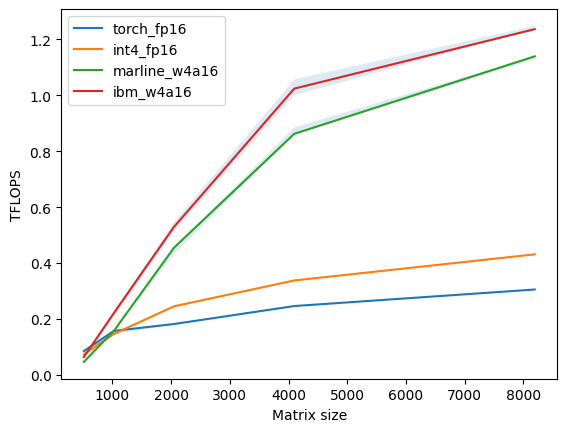

In [12]:
BS = 1
sizes = [1024, 2048, 4096, 8192]
configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],  
        # x_vals=[(BS * size, size, size) for size in sizes],
        x_vals=[(size, BS, size) for size in sizes],
        line_arg="provider",
        line_vals=[
            "torch_fp16",
            # "triton_int2_fp16",
            "triton_int4_fp16",
            # "triton_int4_fp16_scaled",
            # "triton_int4_fp16_bigpack",
            "marline_w4a16",
            "ibm_w4a16"
            ],
        line_names=[
            "torch_fp16", 
            # "int2_fp16",
            "int4_fp16",
            # "int4_fp16_scaled", 
            # "int4_fp16_bigpack",
            "marline_w4a16",
            "ibm_w4a16"
            ],
        ylabel="TFLOPS",
        xlabel="Matrix size",
        plot_name="matmul-performance",
        args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    # M, K = K, M
    
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda").contiguous() / (M * K)
    
    x_compressed_int2 = torch.randint(-128, 128, (K, N // 4), dtype=torch.int8, device="cuda").contiguous()
    x_compressed_int4 = torch.randint(-128, 128, (K, N // 2), dtype=torch.int8, device="cuda").contiguous()
    x_compressed_int4_bigpack = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda").contiguous()
    x_decompressed_fp16 = decode_int8_to_int4(x_compressed_int4).reshape(K, N).to(torch.float16).contiguous()
    scales = torch.abs(torch.randn(N, dtype=torch.float16, device="cuda"))

    # marline
    _, x_compressed_marline, scales_marline = gen_quant4(K, N, groupsize=128)
    
    # imb kernel
    G = 128
    a = make_tensor(M, K, dtype=torch.float16)
    b = make_tensor(K//8, N, dtype=torch.int32)
    zeros = make_tensor(G, N//8, torch.int32)
    scales = make_tensor(G, N, torch.float16)


    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_decompressed_fp16), quantiles=quantiles)
    if provider == "triton_int2_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int2_fp16(y_fp16, x_compressed_int2), quantiles=quantiles)
    if provider == "triton_int4_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int4_fp16(y_fp16, x_compressed_int4), quantiles=quantiles)
    if provider == "triton_int4_fp16_scaled":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int4_fp16_scaled(y_fp16, x_compressed_int4, scales), quantiles=quantiles)
    if provider == "triton_int4_fp16_bigpack":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int4_fp16_bigpack(y_fp16, x_compressed_int4_bigpack), quantiles=quantiles)
    if provider == "marline_w4a16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: marline_matmul(y_fp16, x_compressed_marline, scales_marline), quantiles=quantiles)
    if provider == "ibm_w4a16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_split_k(a, b, scales, zeros), quantiles=quantiles)
    

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=False, print_data=True)

In [13]:
print(matmul_split_k_kernel.best_config)

group_m: 8, block_m: 16, block_n: 64, block_k: 32, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
